In [4]:
import os
from imp import reload
import pandas
import urllib.request

# Installation

The Python Genome Browser can be installed from PyPi using pip:
    
`pip install pygbrowse`    

### Then import it:

In [5]:
import pygbrowse

# Organization

The pygbrowse package is comprised of three modules:

* plots - Subplot classes and a master plotting class
    * BedPlot - Renders discrete genomic intervals such as ChIP-seq peaks, sequence variants, or other regions of interest as colored boxes. Can be colored according to a data field.
    * WigPlot - Named after the wiggle format (though this is, ironically, not currently supported as a data source), this class renders continuous data vectors that have one value (possibly zero) per base pair.
    * InteractionPlot - Renders long-range genomic interactions such as Hi-C, PLAC-seq, Hi-ChIP, etc.
    * GeneModels - Renders annotated transcripts and subtranscript elements.
* datasources
    * Objects that wrap disparate data sources and allow efficient retrieval by the plotting objects.
* utilities
    * Miscellaneous functions used internally by the plots and datasources modules. 
    

Plots are rendered by an instance of the GenomePlotter class. A GenomePlotter is initialized with a collection of subplot objects representing the different data layers to be plotted and can then be used to render plots over different genomic regions using the same data and settings. 


# Demonstration

For this demo we'll be rendering peaks and read profiles for a subset of data from the publication "Analysis of Genetically Diverse Macrophages Reveals Local and Domain-wide Mechanisms that Control Transcription Factor Binding and Function" by Verena Link et al. (<https://doi.org/10.1016/j.cell.2018.04.018>). The raw data is available in GEO under accession number GSE109965 (<http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE109965>) but we will be using tag directories as generated by HOMER (<http://homer.ucsd.edu>) from the read alignments. 

# Gene Models

First we'll demonstrate how to plot gene models (coordinates of transcripts and sub-transcript features such as exons, introns, and UTRs). This feature is based on the display conventions of the UCSC genome browser and uses the same visual representations.

Future improvements:
1. Filter the data to exclude more predicted / spurious transcripts.
2. Move the gene name from above the gene to alonside the gene, a la UCSC genome browser to prevent collisions
3. Cleanup instances of overlapping feature icons.

## The first step is to download a suitable representation of the gene models. Currently we only support GFF3 files from Ensembl but this may be extended in the future.

In [23]:
gff3_filename = 'Mus_musculus.GRCm38.84.chr.gff3.gz'

In [24]:
urllib.request.urlretrieve ('ftp://ftp.ensembl.org/pub/release-84/gff3/mus_musculus/{}'.format(gff3_filename),
                            'data/{}'.format(gff3_filename))

('data/Mus_musculus.GRCm38.84.chr.gff3.gz',
 <email.message.Message at 0x7f082a618320>)

## Next we need to create a an instance of the GeneModels class and pass it the path to a GFF3 file.

In [25]:
gene_models = pygbrowse.plots.GeneModels(os.path.join('data', gff3_filename))

2018-Jul-25 12:54:11	Loading gene model information from data/Mus_musculus.GRCm38.84.chr.gff3.gz. This may take a few minutes ...


### Now we have a subplot object that knows how to render gene models when handed off to a GenomePlotter.

## Finally we initialize a GenomePlotter object and call its .visualize() method with the genomic coordinates we want to display.

### For this demo we will focus on the following region of the mm10 genome: chr4:62468065 -62520077

The key parameter for the GenomePlotteer is a nested 2D list of subplot objects. Each row of the nested list represents a separate subplot. Elements within each row are plotted on the same subplot.

So if you pass 

` [
  [subplot_object_1, subplot_object_2],
  [subplot_object_3]
 ]`
                 
then `subplot_object_1` and `subplot_object_2` will be rendered together at the top, then `subplot_object_3` will be plotted by itself in a subplot below that.

In this case, we just have one subplot_object:

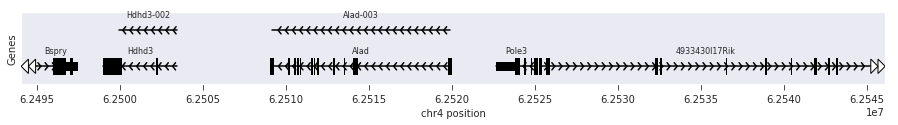

In [88]:
genes_only_plotter = pygbrowse.plots.GenomePlotter([[gene_models]])
fig = genes_only_plotter.visualize('chr4', 62494071, 62546083)

## Let's see if any of these genes are being transcribed in bone-marrow-derived macrophages (BMDMs)

The native format for representing genome-wide vector data in the python genome browser is a dictionary of pandas.Series objects, keyed by chromosome. But in this case we'll use a convenient wrapper class in pygbrowse.datasources to make a HOMER tag directory act like a dictionary of pandas.Series where the value at each base pair represents the number of overlapping reads at that position.

In [68]:
rnaseq_data = pygbrowse.datasources.TagDirectory('data/pooled_rna_notx_c57/')

## Now we can create a WigPlot object that knows how to render that type of data:

In [69]:
rnaseq_plotter = pygbrowse.plots.WigPlot(rnaseq_data, label='RNA-seq', color='orange')

## Let's create a GenomePLotter object with subplots for both the gene models and the RNA-seq data, then visualize the region again.

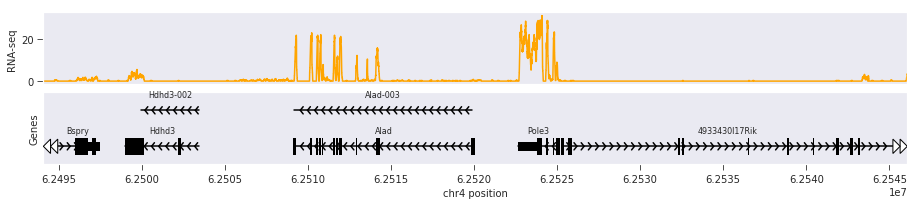

In [91]:
genes_and_rna_plotter = pygbrowse.plots.GenomePlotter([[rnaseq_plotter],
                                                       [gene_models]])
fig = genes_and_rna_plotter.visualize('chr4', 62494071, 62546083)

## OK, it looks like there's evidence for transcription of some of these exons. What about the master myeloid transcription factor Pu.1? We have ChIP-seq data for it, let's take look . . .

### Here we use the same process as for the RNA-seq data, but we can do it all in one line for conciseness

In [71]:
pu1_plotter = pygbrowse.plots.WigPlot(pygbrowse.datasources.TagDirectory('data/pooled_pu1_notx_c57/'), 
                                      label='Pu.1 ChIP-seq', color='darkblue')

## View all together:

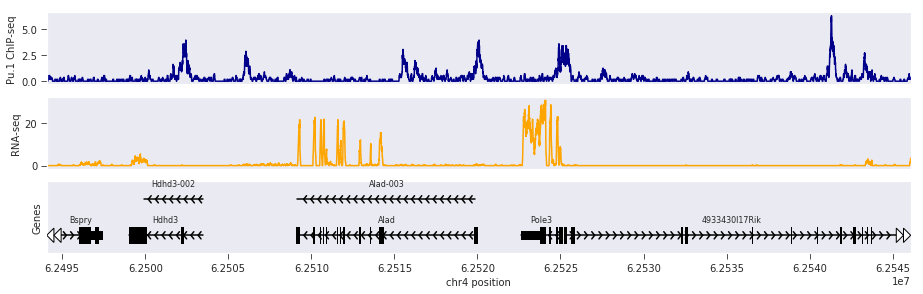

In [92]:
genes_rna_pu1_plotter = pygbrowse.plots.GenomePlotter([[pu1_plotter],
                                                       [rnaseq_plotter], 
                                                       [gene_models]])
fig = genes_rna_pu1_plotter.visualize('chr4', 62494071, 62546083)

## Looks like there are some distinct peaks. Let's see the result of calling peaks on the tag directory using HOMER.

To do this we will bring in a new class for handling genomic intervals: IntervalData.

If you already have a pandas.DataFrame where the index represents a unique identifier for the interval and the first 4 columns are the chromosome, start coordinate, end coordinate and strand of each interval, then you can pass that directly to IntervalData.

Alternatively, it knows how to read such data from 3 different file formats: BED files, HOMER peak files, and annotated HOMER peak files. In these cases, you pass it the path to the file and a format identifier string.

In this case, we will use the annotated HOMER file so that we can demonstrate peak coloring.

In [73]:
pu1_peaks = pygbrowse.datasources.IntervalData('data/pooled_pu1_notx_c57_annotated.homer', format='homer_annotated')

2018-Jul-25 13:51:47	Guessing data/pooled_pu1_notx_c57_annotated.homer is a filename


## Now we can feed this data source to the BedPlot object that knows how to render such data.

We'll also specify that the peaks should be colored by the value in the "Peak Score" column, and to use the YlOrRd colormap.

In [101]:
pu1_peak_plotter = pygbrowse.plots.BedPlot(pu1_peaks, label='Pu.1 peaks', 
                                           color_by='Peak Score', 
                                           cmap='YlOrRd')

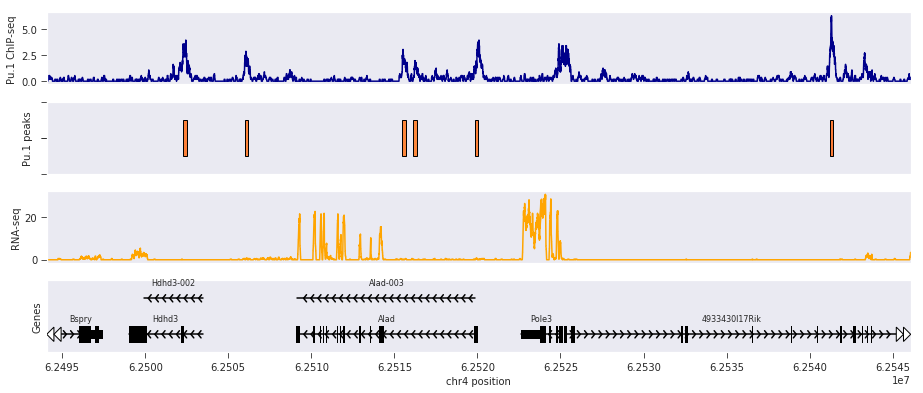

In [102]:
genes_rna_pu1_peaks_plotter = pygbrowse.plots.GenomePlotter([[pu1_plotter],
                                                             [pu1_peak_plotter],
                                                             [rnaseq_plotter], 
                                                             [gene_models]])

fig = genes_rna_pu1_peaks_plotter.visualize('chr4', 62494071, 62546083)

## Now let's examine long-distance interactions in this region, since we also happen to have PLAC-seq data.

This bit is a work-in-progress so there is no datasource class, but in the near future we will natively support BED-PE formats, among others.

In the meantime, we load the data in our modified BED-PE format as a DataFrame . . . 

In [83]:
placseq_data = pandas.read_csv('data/significance_table_all_strains.txt', index_col=0)
placseq_data.head()

,-logQ_BALB,-logQ_NOD,-logQ_C57,-logQ_SPRET,chr1,start1,end1,start2,end2
chr1-105635000-105665000,0.000000,0.000000,2.130456,0.0,chr1,105635000,105640000,105660000,105665000
chr1-105655000-105680000,3.458364,0.000000,0.000000,0.0,chr1,105655000,105660000,105675000,105680000
chr1-105655000-105700000,0.000000,0.000000,2.530036,0.0,chr1,105655000,105660000,105695000,105700000
chr1-105660000-105685000,0.000000,5.961748,3.082902,0.0,chr1,105660000,105665000,105680000,105685000
chr1-105660000-105690000,0.000000,7.568426,3.750340,0.0,chr1,105660000,105665000,105685000,105690000


and pass it directly to the appropriate subplot object. Note that we need to specify the bin size used in generating the interaction data.

In [84]:
placseq_plotter = pygbrowse.plots.InteractionPlot(placseq_data, bin_size=5000)

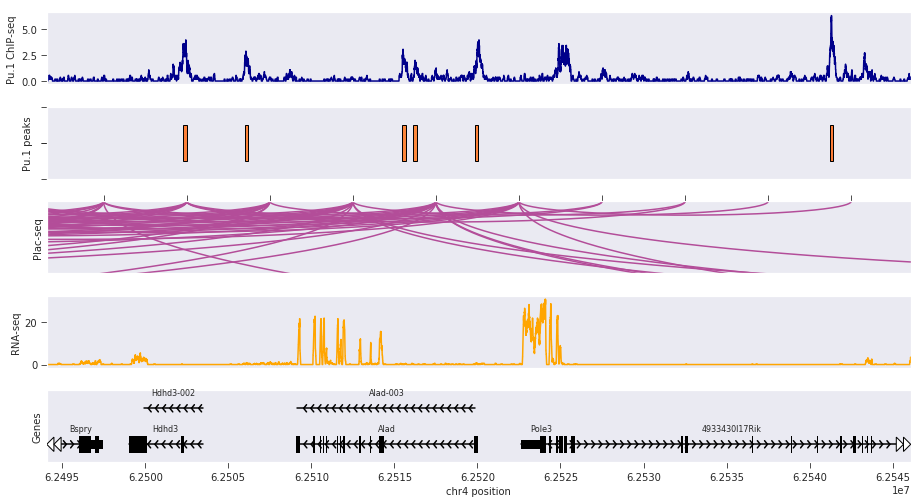

In [103]:
genes_rna_pu1_peaks_placseq_plotter = pygbrowse.plots.GenomePlotter([[pu1_plotter],
                                                             [pu1_peak_plotter],
                                                             [placseq_plotter],
                                                             [rnaseq_plotter], 
                                                             [gene_models]])

fig = genes_rna_pu1_peaks_placseq_plotter.visualize('chr4', 62494071, 62546083)

## Let's shrink the vertical dimension of those PLAC-seq arcs by changing the `vertical_scaling_factor` parameter (default 1)

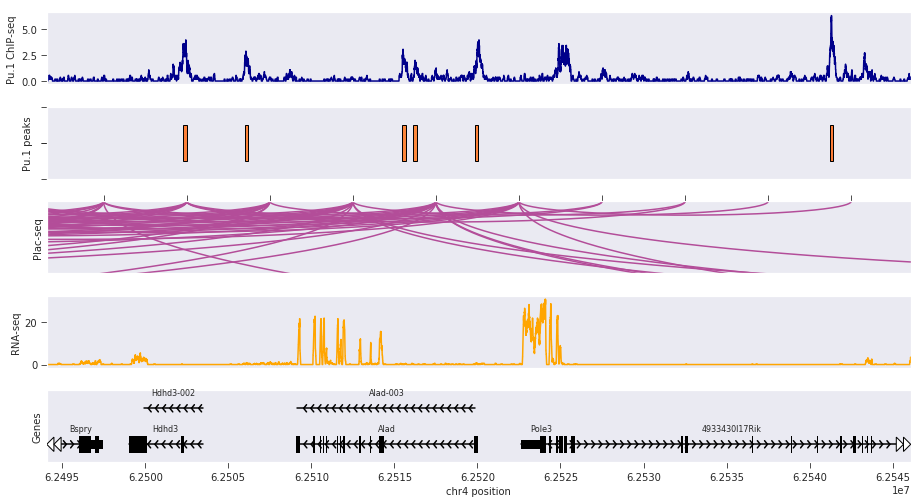

In [104]:
placseq_plotter = pygbrowse.plots.InteractionPlot(placseq_data, bin_size=5000, vertical_scaling_factor=0.5)

genes_rna_pu1_peaks_placseq_plotter = pygbrowse.plots.GenomePlotter([[pu1_plotter],
                                                             [pu1_peak_plotter],
                                                             [placseq_plotter],
                                                             [rnaseq_plotter], 
                                                             [gene_models]])

fig = genes_rna_pu1_peaks_placseq_plotter.visualize('chr4', 62494071, 62546083)

## We can be a little more efficient in our use of vertical space. We don't need quite so much for the peak data and we can use a little more for the gene models and PLAC-seq. So we can specify the height of each individual row in a list:

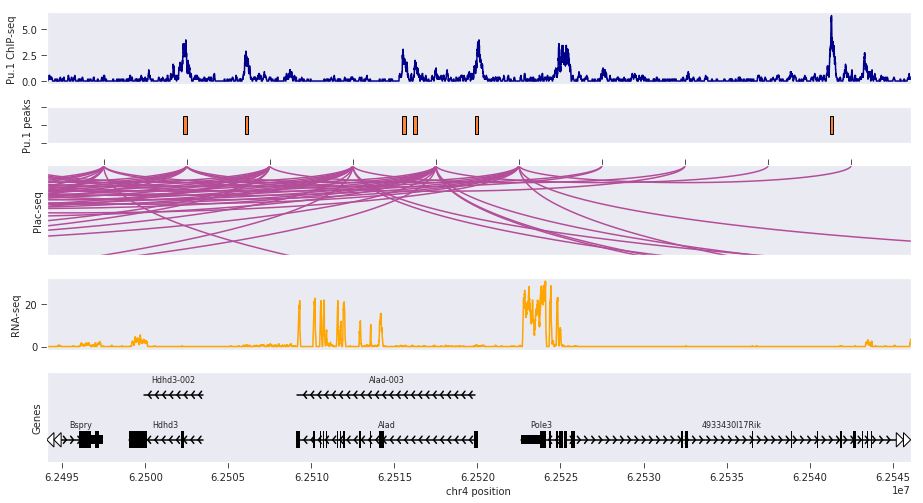

In [107]:
fig = genes_rna_pu1_peaks_placseq_plotter.visualize('chr4', 62494071, 62546083,
                                                   row_heights=[1,0.5,1.25,1,1.25])

## Let's shrink the space between the subplot axes a little more

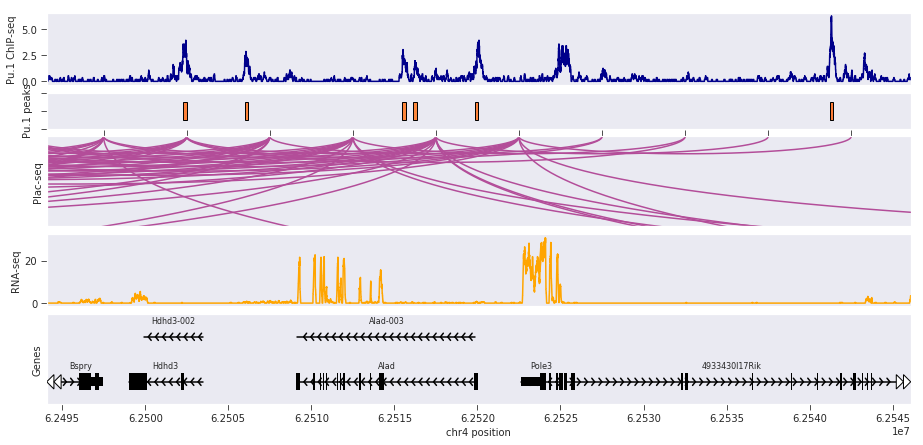

In [110]:
fig = genes_rna_pu1_peaks_placseq_plotter.visualize('chr4', 62494071, 62546083,
                                                   row_heights=[1,0.5,1.25,1,1.25], ax_spacing=0.02)

## Where do all those upstream PLAC-seq interactions go? Let's move the plot start further left by 50,000 bp.

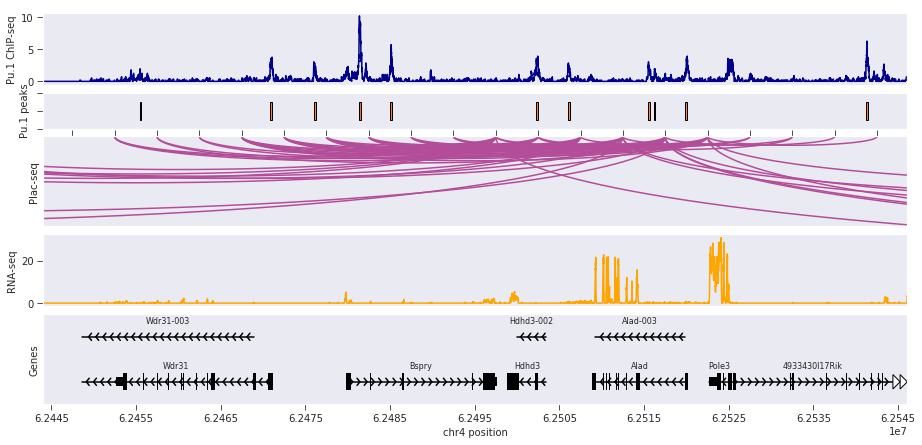

In [111]:
fig = genes_rna_pu1_peaks_placseq_plotter.visualize('chr4', 62444071, 62546083,
                                                   row_heights=[1,0.5,1.25,1,1.25], ax_spacing=0.02)

## Now let's finalize the plot size, add a title and save to disk as both a PDF (for publication) and PNG (for PowerPoint). We'll set the size such that it will completely fill a 16x9 slide.

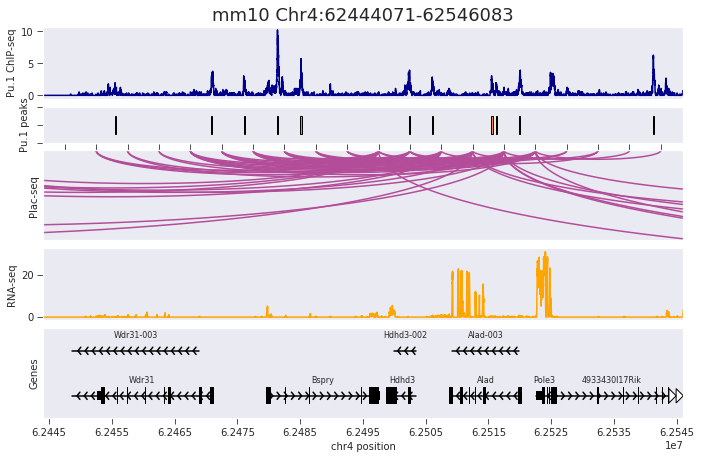

In [121]:
row_heights = [1,0.5,1.25,1,1.25]
aspect_ratio = 16/9
fig_width = sum(row_heights) * aspect_ratio

fig = genes_rna_pu1_peaks_placseq_plotter.visualize('chr4', 62444071, 62546083,
                                                    row_heights = row_heights, 
                                                    fig_width = fig_width,
                                                    ax_spacing = 0.02)

fig.suptitle('mm10 Chr4:62444071-62546083', y=1.05, fontsize=18)
for fig_ext in ('png', 'pdf'):
    fig.savefig('data/example_figure.{}'.format(fig_ext), dpi=600, bbox_inches='tight')

# That's it for now. Coming soon . . . examples of some of the more advanced features and possibilities including multiple datasets on a single subplot axis, using the datasource objects to extract data for other purposes, and more.